In [42]:
import numpy as np
import os

In [43]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [44]:
import PIL
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [45]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [46]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot

In [47]:
def preprocess_image(features):
    """Preprocesses the given image.
       will convert the images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.
       mean = [103.939, 116.779, 123.68]
       std = None
  """
    image = features["image"]
    image = tf.image.resize(image,[224,224])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)
    features["image"] = image
    return features

# Load Data

In [48]:
BATCH_SIZE = 50
tfds_dataset2, tfds_info  = tfds.load(name='imagenet2012_subset', split='validation[-60%:]', with_info=True,
                                     data_dir='/local/rcs/wei/image_net/') # use the last 20% of images among 50000 validation images for testing
#tf.compat.v1.data.make_one_shot_iterator(tfds_dataset1).get_next()

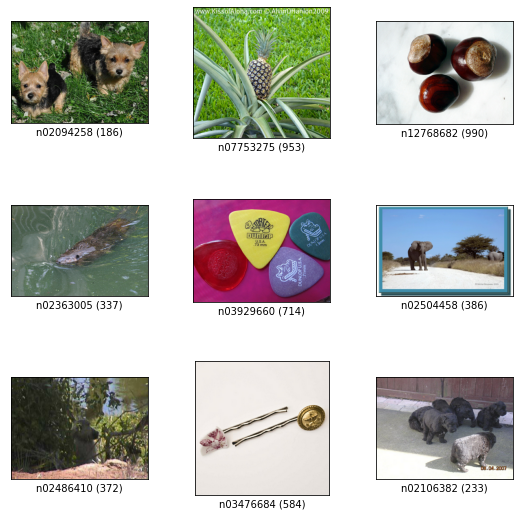

In [49]:
figs = tfds.show_examples(tfds_dataset2, tfds_info)

In [50]:
val_ds = tfds_dataset2.map(preprocess_image).batch(BATCH_SIZE).prefetch(1)

# Load Model

In [51]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
model_ = ResNet50(input_shape=input_shape)

In [52]:
q_model = tfmot.quantization.keras.quantize_model(model_)

In [53]:
model = ResNet50(input_tensor = q_model.input)

In [54]:
model.load_weights("./original_model_40.h5")
q_model.load_weights("./int8_model_40.h5")

# Display Image

In [55]:
def extract(ith_image):
    for i, features in enumerate(val_ds):
        if ith_image < 50 and i == 0:
            image = np.expand_dims(features["image"].numpy()[ith_image], axis=0)
            label = features["label"].numpy()[ith_image]
            logits_1 = model(image)
            logits_2 = q_model(image)
            predict_1 = tf.argmax(logits_1, axis=-1).numpy()[0]
            predict_2 = tf.argmax(logits_2, axis=-1).numpy()[0]
            break
        
        elif i == np.floor(ith_image/50):
            image = np.expand_dims(features["image"].numpy()[ith_image%50], axis=0)
            label = features["label"].numpy()[ith_image%50]
            logits_1 = model(image)
            logits_2 = q_model(image)
            predict_1 = tf.argmax(logits_1, axis=-1).numpy()[0]
            predict_2 = tf.argmax(logits_2, axis=-1).numpy()[0]
            break
    return image, label,logits_1,logits_2,predict_1,predict_2

In [56]:
image,label,logits_1,logits_2,predict_1,predict_2 = extract(1)

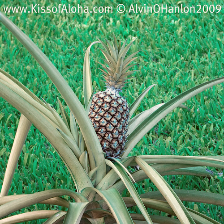

In [63]:
pil_img = tf.keras.preprocessing.image.array_to_img(image[0,:,:,:])
from IPython.display import Image
display(pil_img)

In [64]:
tf.keras.applications.resnet.decode_predictions(logits_1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.99969995),
 ('n07730033', 'cardoon', 0.000121142155),
 ('n04311004', 'steel_arch_bridge', 2.4950794e-05),
 ('n03991062', 'pot', 2.1274973e-05),
 ('n03457902', 'greenhouse', 2.0334668e-05)]

In [65]:
tf.keras.applications.resnet.decode_predictions(logits_2.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.9847431),
 ('n03457902', 'greenhouse', 0.0022542304),
 ('n04311004', 'steel_arch_bridge', 0.0021020828),
 ('n07730033', 'cardoon', 0.0017045278),
 ('n04523525', 'vault', 0.0009087971)]

In [20]:
#np.save("./trailer_truck.npy",image)

# Baseline: PGD

$ A = argmax_A \,\, [ \,\, L( \,\, model_{quant} \,\, (image + A) , y )\,\, ]$

In [41]:
grad_iterations = 20
step = 1
epsilon = 8
input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0
loss = tf.keras.losses.SparseCategoricalCrossentropy()
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        predict = q_model(input_image + A)
        final_loss = loss(orig_label , predict)


        grads = normalize(g.gradient(final_loss, input_image))
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= model(test_image), q_model(test_image)
    print(tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0])
    print(tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0])
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Oh no!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

[('n13133613', 'ear', 0.5731049), ('n12144580', 'corn', 0.42524278), ('n02823428', 'beer_bottle', 0.0013777373), ('n03496892', 'harvester', 0.00017137725), ('n03983396', 'pop_bottle', 7.213191e-05)]
[('n13133613', 'ear', 0.9168864), ('n12144580', 'corn', 0.07945405), ('n02823428', 'beer_bottle', 0.0010435308), ('n03496892', 'harvester', 0.0007358046), ('n03877845', 'palace', 0.00031811182)]
[('n03496892', 'harvester', 0.4188406), ('n02823428', 'beer_bottle', 0.3141045), ('n13133613', 'ear', 0.14691937), ('n03983396', 'pop_bottle', 0.05218601), ('n12144580', 'corn', 0.046664372)]
[('n13133613', 'ear', 0.35295695), ('n02825657', 'bell_cote', 0.1636393), ('n03496892', 'harvester', 0.14229527), ('n03877845', 'palace', 0.115383774), ('n04346328', 'stupa', 0.016307417)]
different
[('n03496892', 'harvester', 0.94499564), ('n02823428', 'beer_bottle', 0.029028516), ('n03983396', 'pop_bottle', 0.0082449205), ('n04204347', 'shopping_cart', 0.0063634026), ('n03967562', 'plow', 0.0039360714)]
[('n0

In [39]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n02823428', 'beer_bottle', 0.374856),
 ('n04346328', 'stupa', 0.1806805),
 ('n03220513', 'dome', 0.16240703),
 ('n04435653', 'tile_roof', 0.1585635),
 ('n03877845', 'palace', 0.06814978)]

In [40]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n04346328', 'stupa', 0.22985208),
 ('n03781244', 'monastery', 0.22985208),
 ('n02825657', 'bell_cote', 0.22985208),
 ('n03220513', 'dome', 0.15113235),
 ('n03877845', 'palace', 0.0864109)]

# Generate adverserial example

## 1. A = argmax c*L( q_model(image + A) , sudo_y) -  L( orig_model(image + A) , y) 

In [19]:
#image = np.load("./trailer_truck.npy")

In [66]:
c = 1e2
grad_iterations = 20
step = 1
epsilon = 8

In [67]:
input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0

In [68]:
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = tf.keras.losses.MSE(model(input_image + A)[0] , q_model(input_image + A)[0])
        # increases this loss, c should be large to make this more importatnt
        loss2 = tf.keras.losses.MSE(orig_logist[0] , model(input_image + A)[0])
        # decreases this loss
        final_loss = loss1 - c*loss2
        #print(final_loss)


        grads = normalize(g.gradient(final_loss, input_image))
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= model(test_image), q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

different
Success!


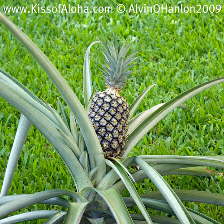

In [69]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

In [70]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.9852769),
 ('n07730033', 'cardoon', 0.0031385412),
 ('n04311004', 'steel_arch_bridge', 0.0018055522),
 ('n03457902', 'greenhouse', 0.0011304957),
 ('n03891251', 'park_bench', 0.0009329525)]

In [71]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n04311004', 'steel_arch_bridge', 0.32512894),
 ('n07753275', 'pineapple', 0.106286645),
 ('n03457902', 'greenhouse', 0.074943826),
 ('n04523525', 'vault', 0.045951102),
 ('n03891251', 'park_bench', 0.032400608)]

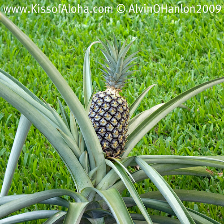

In [72]:
tf.keras.preprocessing.image.array_to_img(orig_img_deprocessed)

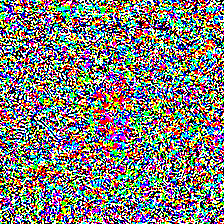

In [73]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed - orig_img_deprocessed)

# Transferability

In [87]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
model__ = ResNet50(input_shape=input_shape)
t_q_model = tfmot.quantization.keras.quantize_model(model__)
t_model = ResNet50(input_tensor = q_model.input)
t_model.load_weights("./transferability_original_model_40.h5")
t_q_model.load_weights("./transferability_q_model_40.h5")

In [88]:
input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(t_model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0

In [89]:
pred1, pred2= t_model(input_image), t_q_model(input_image)

In [90]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.9998584),
 ('n07730033', 'cardoon', 8.528743e-05),
 ('n03991062', 'pot', 9.311455e-06),
 ('n03457902', 'greenhouse', 7.3394053e-06),
 ('n11939491', 'daisy', 5.935758e-06)]

In [91]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.985115),
 ('n03457902', 'greenhouse', 0.0022353348),
 ('n07730033', 'cardoon', 0.0020734745),
 ('n04311004', 'steel_arch_bridge', 0.0013207971),
 ('n04523525', 'vault', 0.0006228716)]

In [92]:
c = 1e2
grad_iterations = 20
step = 1
epsilon = 8

In [93]:
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = tf.keras.losses.MSE(t_model(input_image + A)[0] , t_q_model(input_image + A)[0])
        # increases this loss, c should be large to make this more importatnt
        loss2 = tf.keras.losses.MSE(orig_logist[0] , t_model(input_image + A)[0])
        # decreases this loss
        final_loss = loss1 - c*loss2
        #print(final_loss)


        grads = normalize(g.gradient(final_loss, input_image))
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= t_model(test_image), t_q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    pred3, pred4= model(test_image), q_model(test_image)
    label3, label4 = np.argmax(pred3[0]), np.argmax(pred4[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6\
            and tf.keras.applications.resnet.decode_predictions(pred4.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

different
different
different
different
different
different
different
different
different
Success!


In [94]:
pred1, pred2= model(test_image), q_model(test_image)

In [95]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.761649),
 ('n02096177', 'cairn', 0.0683009),
 ('n03065424', 'coil', 0.028439429),
 ('n03891251', 'park_bench', 0.024870502),
 ('n04501370', 'turnstile', 0.011246435)]

In [96]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n02096177', 'cairn', 0.79203093),
 ('n02097298', 'Scotch_terrier', 0.029672889),
 ('n02113712', 'miniature_poodle', 0.009700247),
 ('n02093754', 'Border_terrier', 0.009045536),
 ('n02097209', 'standard_schnauzer', 0.008435014)]

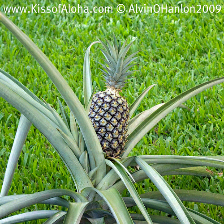

In [97]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

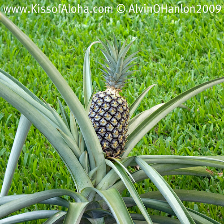

In [98]:
tf.keras.preprocessing.image.array_to_img(orig_img_deprocessed)

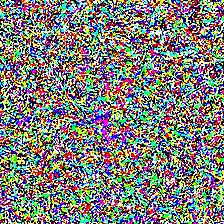

In [99]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed - orig_img_deprocessed)

## 2. A = argmax orig_model(image + A)[y] - c*q_model(image + A)[y]

In [85]:
image = np.load("./trailer_truck.npy")

In [86]:
c = 1
grad_iterations = 20
step = 1
epsilon = 8

input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0

In [87]:
for iters in range(grad_iterations):

    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = K.mean(model(input_image+A)[..., orig_label])
        loss2 = K.mean(q_model(input_image+A)[..., orig_label])
        final_loss = K.mean(loss1 - c*loss2)

        grads = normalize(g.gradient(final_loss, input_image))

        # input_image += grads * step    
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= model(test_image), q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

different
Success!


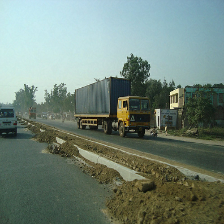

In [89]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

In [90]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n04467665', 'trailer_truck', 0.73986655),
 ('n03393912', 'freight_car', 0.104042545),
 ('n03895866', 'passenger_car', 0.06456896),
 ('n03776460', 'mobile_home', 0.037595745),
 ('n03272562', 'electric_locomotive', 0.031142091)]

In [91]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n03393912', 'freight_car', 0.629599),
 ('n04467665', 'trailer_truck', 0.16689421),
 ('n03776460', 'mobile_home', 0.047442466),
 ('n03272562', 'electric_locomotive', 0.038469944),
 ('n03895866', 'passenger_car', 0.035873435)]

In [92]:
print(A)

tf.Tensor(
[[[[ 1.  1.  1.]
   [ 1.  1. -1.]
   [-1.  1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[ 1.  1. -1.]
   [ 1.  1.  1.]
   [ 1.  1.  1.]
   ...
   [-1. -1. -1.]
   [ 1. -1.  1.]
   [-1. -1. -1.]]

  [[ 1.  1.  1.]
   [ 1.  1.  1.]
   [ 1.  1.  1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  ...

  [[-1. -1.  1.]
   [-1. -1.  1.]
   [-1.  1.  1.]
   ...
   [ 1.  1.  1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [ 1. -1. -1.]
   [ 1. -1.  1.]
   ...
   [ 1.  1.  1.]
   [-1.  1.  1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [ 1. -1.  1.]
   ...
   [ 1.  1.  1.]
   [-1. -1. -1.]
   [ 1.  1.  1.]]]], shape=(1, 224, 224, 3), dtype=float32)


# 3. Cross Entropy Loss

In [93]:
image = np.load("./trailer_truck.npy")

In [94]:
c = 1
grad_iterations = 100
transformation = 'light'
step = 1

input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_label =  np.argmax(orig_logist[0])
A = 0
epsilon = 8

In [95]:
for iters in range(grad_iterations):

    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = tf.keras.losses.categorical_crossentropy(model(input_image+A)[0] , q_model(input_image+A)[0])
        # increases this loss, c should be large to make this more importatnt
        loss2 = tf.keras.losses.categorical_crossentropy(orig_logist[0] , model(input_image+A)[0])
        # decreases this loss
        final_loss = loss1 - c*loss2
        print(final_loss)

    grads = normalize(g.gradient(final_loss, input_image))
    
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= model(test_image), q_model(test_image)
    label_ = np.argmax(pred1[0])
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        print(label1)
        print(label2)
        print(tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0])
        print(tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0])
        if label_ == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

tf.Tensor(0.3754797, shape=(), dtype=float32)
different
779
565
[('n04146614', 'school_bus', 0.75182736), ('n03272562', 'electric_locomotive', 0.12491274), ('n03769881', 'minibus', 0.05344212), ('n03895866', 'passenger_car', 0.040773574), ('n04335435', 'streetcar', 0.009641159)]
[('n03393912', 'freight_car', 0.5083945), ('n03272562', 'electric_locomotive', 0.21979518), ('n03769881', 'minibus', 0.07185236), ('n03895866', 'passenger_car', 0.06700275), ('n04310018', 'steam_locomotive', 0.033312485)]
tf.Tensor(-4.2410603, shape=(), dtype=float32)
tf.Tensor(-2.9253335, shape=(), dtype=float32)
tf.Tensor(-1.4447447, shape=(), dtype=float32)
tf.Tensor(0.47527504, shape=(), dtype=float32)
different
41
525
[('n01685808', 'whiptail', 0.18073148), ('n01695060', 'Komodo_dragon', 0.08943513), ('n01689811', 'alligator_lizard', 0.071047254), ('n01675722', 'banded_gecko', 0.05828792), ('n01697457', 'African_crocodile', 0.05704562)]
[('n03160309', 'dam', 0.047729567), ('n04486054', 'triumphal_arch', 0.

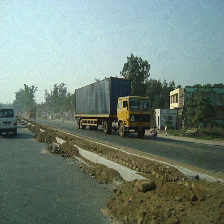

In [96]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

In [97]:
print(A)

tf.Tensor(
[[[[-4. -2. -2.]
   [-2.  0.  0.]
   [ 0. -2. -7.]
   ...
   [-6. -6. -2.]
   [ 0.  0. -2.]
   [ 2.  2.  2.]]

  [[-2.  0.  2.]
   [-2. -2. -4.]
   [ 0.  4. -2.]
   ...
   [ 2.  2.  0.]
   [ 2.  2.  6.]
   [-2. -2. -4.]]

  [[ 4.  0.  0.]
   [ 0.  2.  2.]
   [ 4.  6.  8.]
   ...
   [ 0.  2.  6.]
   [-2.  2. -2.]
   [-4. -2. -2.]]

  ...

  [[ 0.  0.  0.]
   [ 2. -2. -2.]
   [ 2.  4.  4.]
   ...
   [ 2.  2.  0.]
   [ 2.  4. -4.]
   [ 2.  0. -2.]]

  [[ 0. -4.  4.]
   [ 0. -2.  0.]
   [ 4. -2.  0.]
   ...
   [ 6.  4.  2.]
   [ 2.  2.  6.]
   [ 2. -2.  2.]]

  [[ 0.  0.  2.]
   [ 2.  0.  4.]
   [-2. -2.  2.]
   ...
   [ 0.  0. -2.]
   [ 0.  2.  4.]
   [ 0. -4.  2.]]]], shape=(1, 224, 224, 3), dtype=float32)


In [98]:
test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(gen_img_deprocessed), axis=0)
pred1, pred2= model(test_image), q_model(test_image)
label_ = np.argmax(pred1[0])
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])

In [99]:
label1, label2

(867, 170)